In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_groups: 
        - "04_24_24_UniverSeg_VaryThreshold"
    
calibration:
    metric_cfg_file: "/storage/vbutoi/projects/ESE/ese/experiment/configs/inference/Calibration_Metrics.yaml"

options:
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    remove_shared_columns: False
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

In [3]:
from ese.experiment.analysis.analyze_inf import load_cal_inference_stats

image_info_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False,
)

/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'fillNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'isNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'notNA' for type <class 'pandas.core.series.Series'> is overridi

Dropping (datapoint, metric) pairs with NaN metric score. Dropped from 70200 -> 70200 rows.
/storage/vbutoi/scratch/ESE/inference/04_24_24_UniverSeg_VaryThreshold/ACDC_Ensemble_Uncalibrated                20240424_004103-S8C8-68bdb6f2efe5a257ccdef3b4b3d6ec6c    2460
                                                                                                                 20240424_004108-UDH1-36cbe1db30ee25893720a4c23388e16a    2460
                                                                                                                 20240424_004112-UVL8-5c8fc77ce210c90f8453d4451522a7b4    2460
                                                                                                                 20240424_004116-Y4BK-5ce27d11d3c2df741c54d8d9caefdd0d    2460
                                                                                                                 20240424_004120-HGP2-41f945f0b2b6c87d8175ebcc4d53fb03    2460
                                 

In [4]:
image_info_df.keys()

Index(['sup_idx', 'data_id', 'label_idx', 'split', 'slice_idx', 'image_metric',
       'metric_score', 'groupavg_image_metric', 'groupavg_metric_score',
       'num_lab_0_pixels', 'num_lab_1_pixels', 'ECE', 'Edge-ECE', 'CW-ECE',
       'ECW-ECE', 'Uniform-CW-ECE', 'Uniform-ECW-ECE', 'log_set',
       'calibrator._class', 'calibrator._name', 'calibrator.normalize',
       'data.input_type', 'data.labels', 'data.preload', 'data.resolution',
       'data.slicing', 'data.splits', 'data.support_size', 'data.task',
       'dataloader.batch_size', 'dataloader.num_workers',
       'dataloader.pin_memory', 'dataset._class', 'dataset.labels',
       'dataset.min_label_density', 'dataset.preload', 'dataset.resolution',
       'dataset.return_data_id', 'dataset.samples_per_epoch',
       'dataset.slicing', 'dataset.support_size', 'dataset.task',
       'dataset.version', 'ensemble.combine_fn', 'ensemble.combine_quantity',
       'ensemble.normalize', 'ensemble.num_members', 'experiment.dataset_nam

In [5]:
def task(dataset_name, label_idx):
    return f"{dataset_name}_{label_idx}"

image_info_df.augment(task)

In [6]:
image_info_df['task'].unique()

array(['WBC_0', 'WBC_1', 'ACDC_0', 'ACDC_1', 'ACDC_2', 'STARE_0',
       'PanDental_Jaw_0', 'SpineWeb_0', 'PanDental_Mandible_0'],
      dtype=object)

In [7]:
# We want to compare how Dice relates to ECE, this means we need to pivot our dataframe
df_pivot = image_info_df.pivot(index=['data_id', 'sup_idx', 'task', 'dataset_name', 'threshold'], columns='image_metric', values='metric_score').reset_index()

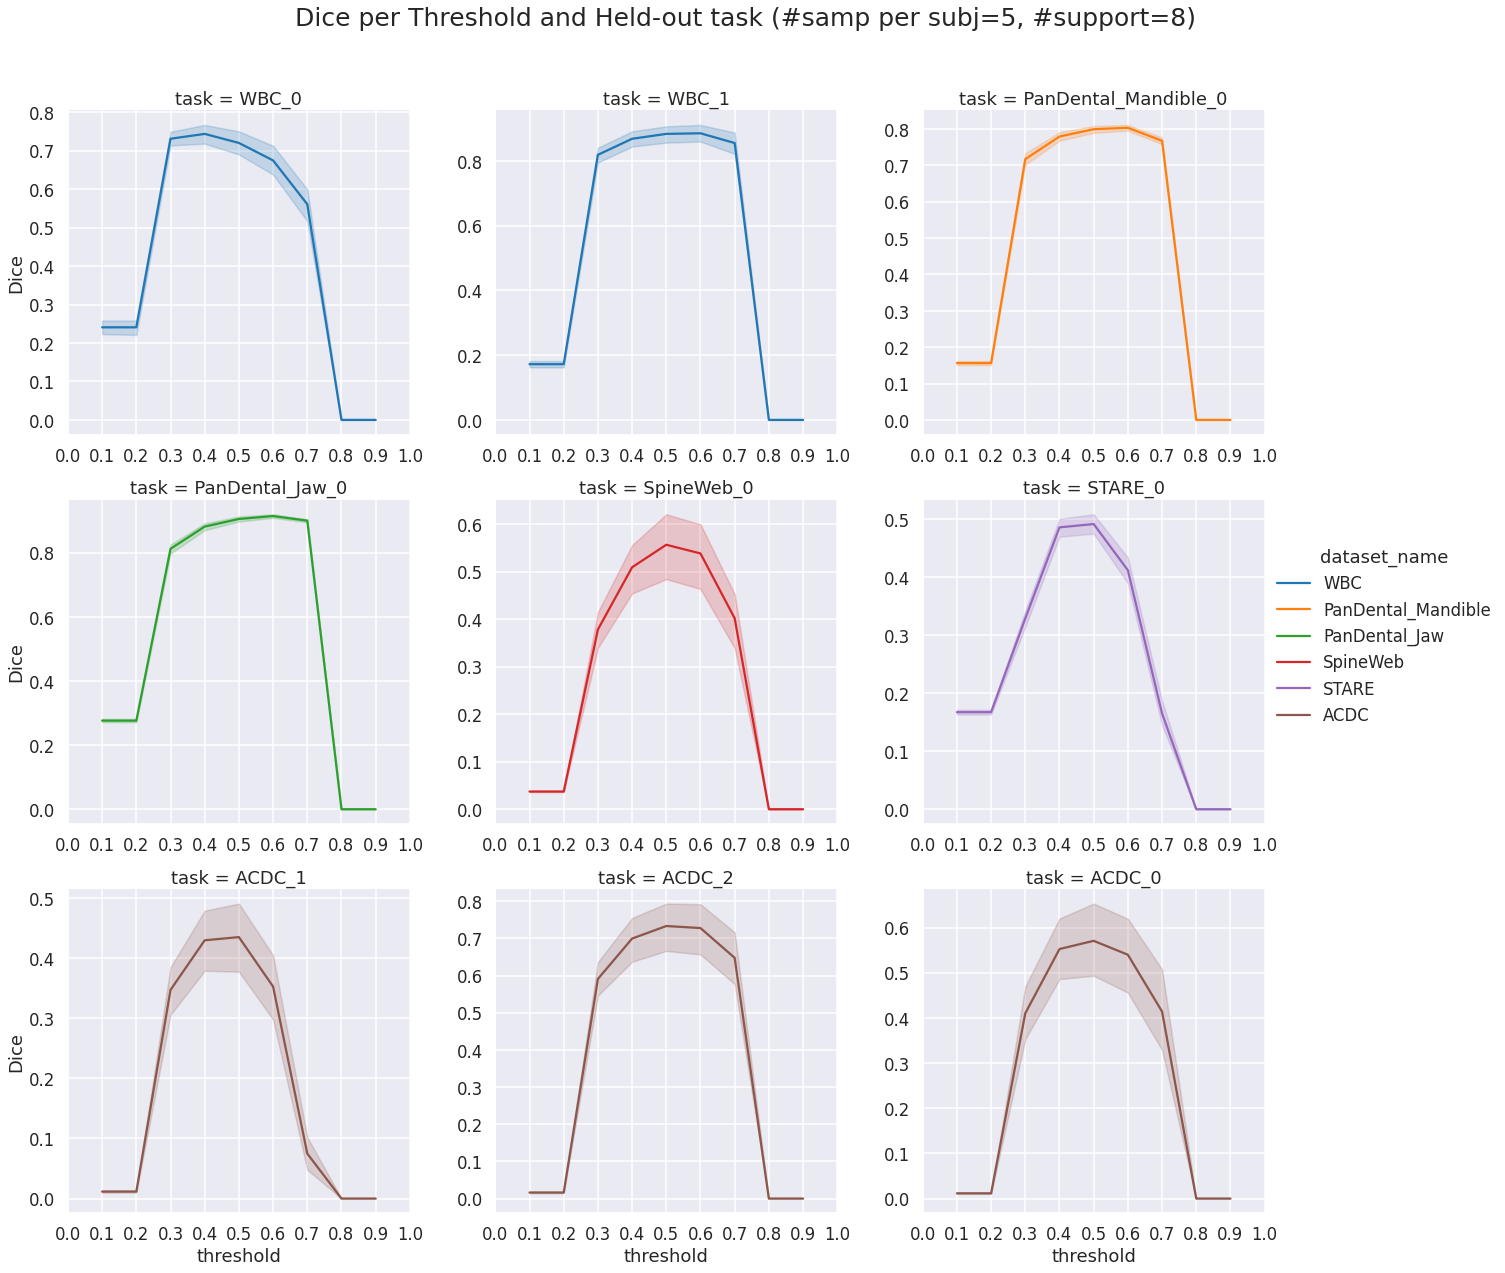

In [8]:
# set the figsize
g = sns.relplot(
    data=df_pivot,
    x='threshold',
    y='Dice',
    kind='line',
    hue='dataset_name',
    col="task",
    col_wrap=3,
    height=6,
    facet_kws={
        "sharex":False,
        "sharey":False
    }
)
# set the y axis label to be dice score
g.fig.subplots_adjust(wspace=0.25, hspace=0.2)

g.fig.suptitle("Dice per Threshold and Held-out task (#samp per subj=5, #support=8)", fontsize=25)
g.fig.subplots_adjust(top=0.9)

# Set ticks for every 0.1 between 0 and 1 for every subplot
for ax in g.axes.flat:
    ax.set_xticks([0.1 * i for i in range(11)])
    ax.set_xticklabels([f"{0.1 * i:.1f}" for i in range(11)])


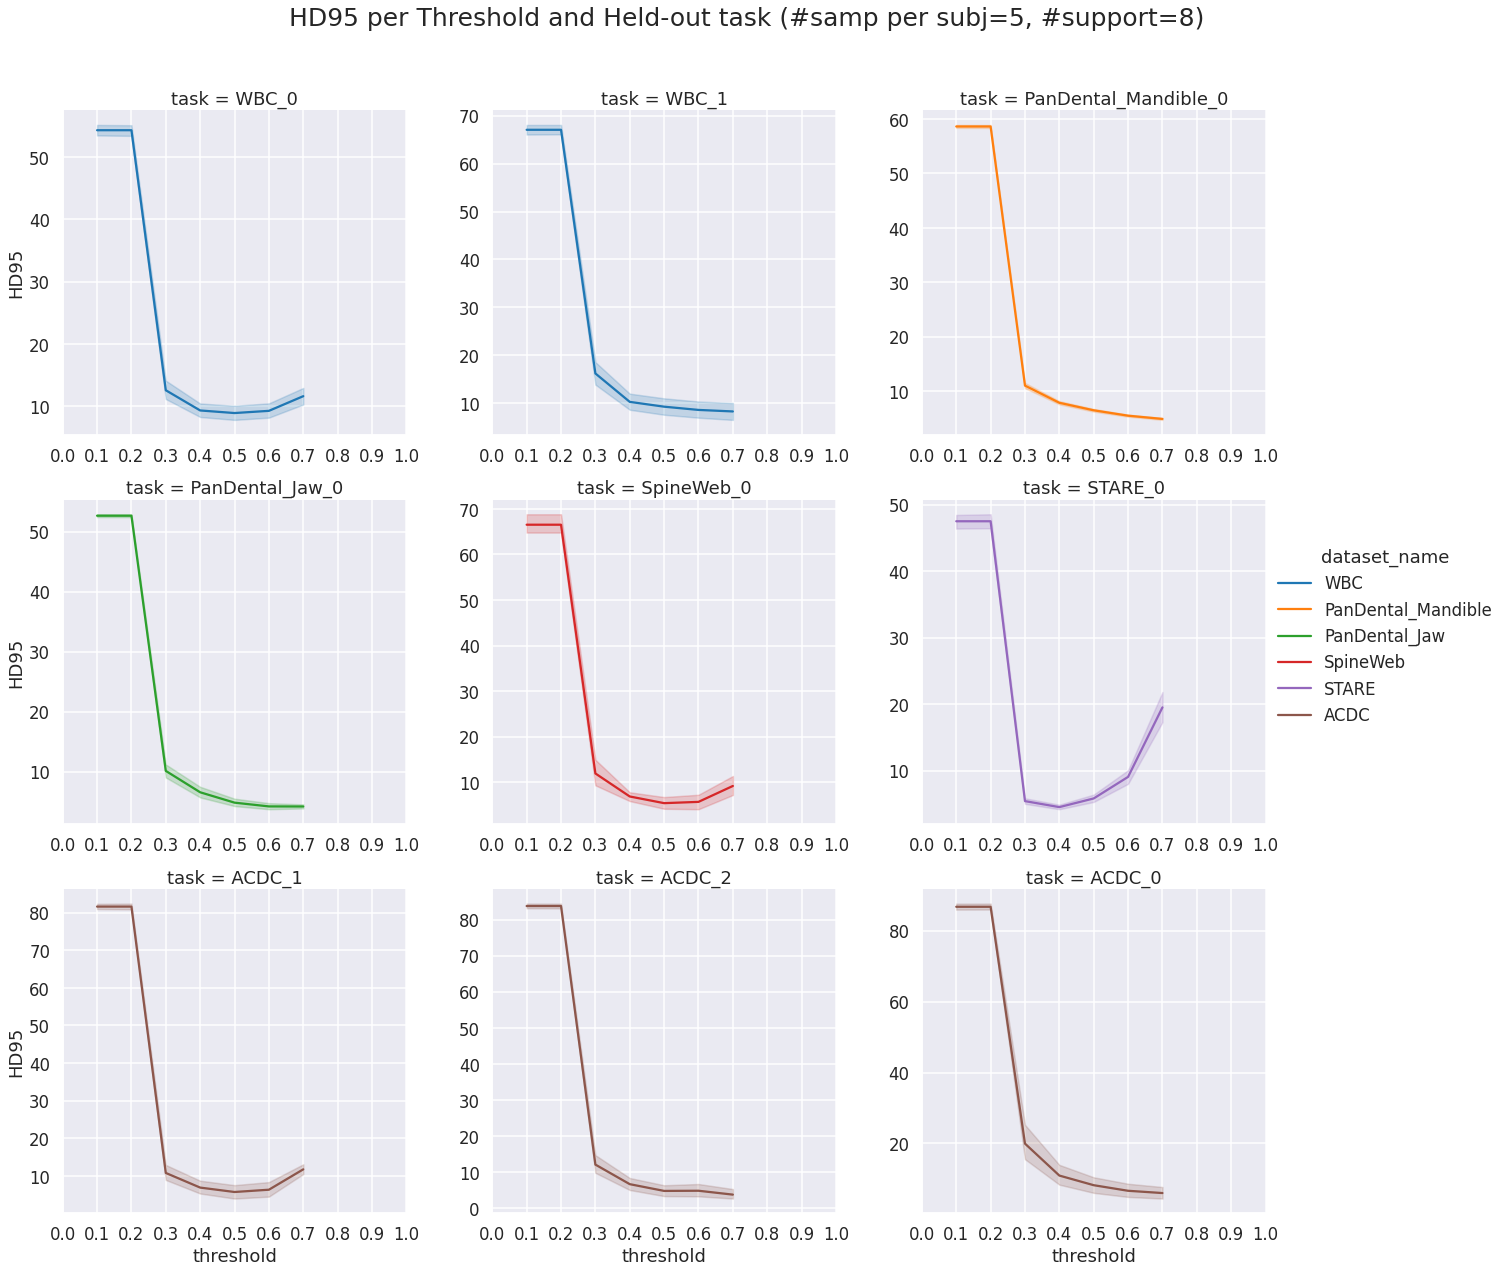

In [9]:
# set the figsize
g = sns.relplot(
    data=df_pivot,
    x='threshold',
    y='HD95',
    kind='line',
    hue='dataset_name',
    col="task",
    col_wrap=3,
    height=6,
    facet_kws={
        "sharex":False,
        "sharey":False
    }
)
# set the y axis label to be dice score
g.fig.subplots_adjust(wspace=0.25, hspace=0.2)

g.fig.suptitle("HD95 per Threshold and Held-out task (#samp per subj=5, #support=8)", fontsize=25)
g.fig.subplots_adjust(top=0.9)

# Set ticks for every 0.1 between 0 and 1 for every subplot
for ax in g.axes.flat:
    ax.set_xticks([0.1 * i for i in range(11)])
    ax.set_xticklabels([f"{0.1 * i:.1f}" for i in range(11)])
